In [1]:
import nnts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import nnts.data
import nnts.experiments
import nnts.models
import nnts.torch.data.preprocessing as preprocessing
import nnts.torch.models
import nnts.torch.models.trainers as trainers
import nnts.metrics
import nnts.torch.data
import nnts.torch.data.datasets
import nnts.loggers
from typing import List
import covs 

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
df_orig, metadata = nnts.data.load("hospital")
params = nnts.models.Hyperparams()
splitter = nnts.data.PandasSplitter()

model_name = "base-lstm"
PATH = f"results/{model_name}/{metadata.dataset}"

In [33]:
scenario_list: List[nnts.experiments.CovariateScenario] = []

# Add the baseline scenarios
for seed in [42, 43, 44, 45, 46]:
    scenario_list.append(
        nnts.experiments.CovariateScenario(metadata.prediction_length, error=0.0, covariates=0, seed=seed)
    )

# Models for full forecast horizon with covariates
for covariates in [1, 2, 3]:
    for error in covs.errors[metadata.dataset]:
        scenario_list.append( 
            nnts.experiments.CovariateScenario(
                metadata.prediction_length, error, covariates=covariates
            )
        )

# Models with short forecast horizon with covariates
for covariates in [1, 2, 3]:
    for error in covs.errors[metadata.dataset]:
        scenario = nnts.experiments.CovariateScenario(
            covariates, error, covariates=covariates
        )
        scenario_list.append(scenario)

In [34]:
[
    {
        **params.__dict__,
        **metadata.__dict__,
        **scenario.__dict__,
    } for scenario in scenario_list
]

[{'input_dim': 1,
  'hidden_dim': 40,
  'n_layers': 2,
  'dropout': 0.1,
  'output_dim': 1,
  'batch_size': 128,
  'lr': 0.001,
  'epochs': 100,
  'patience': 10,
  'rnn_type': 'lstm',
  'path': '/Users/garethdavies/Downloads/hospital_dataset.tsf',
  'dataset': 'hospital',
  'context_length': 15,
  'prediction_length': 12,
  'freq': 'M',
  'seasonality': 12,
  'error': 0.0,
  'conts': [],
  'pearson': 0,
  'noise': 0,
  'covariates': 0,
  'seed': 42},
 {'input_dim': 1,
  'hidden_dim': 40,
  'n_layers': 2,
  'dropout': 0.1,
  'output_dim': 1,
  'batch_size': 128,
  'lr': 0.001,
  'epochs': 100,
  'patience': 10,
  'rnn_type': 'lstm',
  'path': '/Users/garethdavies/Downloads/hospital_dataset.tsf',
  'dataset': 'hospital',
  'context_length': 15,
  'prediction_length': 12,
  'freq': 'M',
  'seasonality': 12,
  'error': 0.0,
  'conts': [],
  'pearson': 0,
  'noise': 0,
  'covariates': 0,
  'seed': 43},
 {'input_dim': 1,
  'hidden_dim': 40,
  'n_layers': 2,
  'dropout': 0.1,
  'output_dim':

In [35]:
params.epochs = 10

In [36]:
for scenario in scenario_list:
    nnts.torch.data.datasets.seed_everything(scenario.seed)
    df, scenario = covs.prepare(df_orig.copy(), scenario)
    split_data = splitter.split(df, metadata)
    trn_dl, val_dl, test_dl = nnts.data.map_to_dataloaders(
        split_data,
        metadata,
        scenario,
        params,
        nnts.torch.data.TorchTimeseriesDataLoaderFactory(),
    )
    name = f"cov-{scenario.covariates}-pearsn-{str(round(scenario.pearson, 2))}-pl-{str(scenario.prediction_length)}-seed-{scenario.seed}"
    logger = nnts.loggers.ProjectRun(
        nnts.loggers.JsonFileHandler(
            path=PATH, filename=f"{name}.json"
        ),
        #nnts.loggers.PrintHandler(),
        project=f"{model_name}-{metadata.dataset}",
        run=name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
    )

    net = nnts.torch.models.BaseLSTM(
        nnts.torch.models.LinearModel,
        params,
        preprocessing.masked_mean_abs_scaling,
        scenario.covariates + 1,
    )
    trner = trainers.TorchEpochTrainer(
        nnts.models.TrainerState(), 
        net, 
        params, 
        metadata, 
        f"{PATH}/{name}.pt",
        logger=logger
    )
    evaluator = trner.train(trn_dl, val_dl)
    y_hat, y  = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, metadata.freq, metadata.seasonality
    )
    logger.log(test_metrics)
    logger.finish()

BaseLSTM(
  (decoder): BaseLSTMDecoder(
    (rnn): LSTM(2, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=1, bias=True)
    )
  )
)
Artifact saved to results/base-lstm/hospital/cov-0-pearsn-0-pl-12-seed-42.pt
{'train_loss': 115.17772674560547, 'valid_loss': 20.87915802001953, 'elapsed_time': 3.9499207502231}
Artifact saved to results/base-lstm/hospital/cov-0-pearsn-0-pl-12-seed-42.pt
{'train_loss': 25.76076889038086, 'valid_loss': 19.483318328857422, 'elapsed_time': 4.160603249911219}
{'train_loss': 22.064151763916016, 'valid_loss': 19.876571655273438, 'elapsed_time': 3.9243928329087794}
Artifact saved to results/base-lstm/hospital/cov-0-pearsn-0-pl-12-seed-42.pt
{'train_loss': 21.403871536254883, 'valid_loss': 19.276002883911133, 'elapsed_time': 3.8174818330444396}
{'train_loss': 19.60988998413086, '

In [5]:
def add_y_hat(df, y_hat, prediction_length):
    i = 0
    df_list = []
    for name, group in df.groupby("unique_id", sort=False):
        group["y_hat"] = None
        group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
        i += 1
        df_list.append(group)
    return df_list


def plot(df_test, prediction_length, start_idx=0):
    num_plots = min(len(df_test), 4)
    fig, axes = plt.subplots(
        nrows=num_plots // 2 + num_plots % 2, ncols=min(num_plots, 2), figsize=(20, 10)
    )
    axes = np.ravel(axes)  # Flatten the axes array

    for idx, ax in enumerate(axes):
        if idx < len(df_test):
            df_test[start_idx + idx].set_index("ds").tail(prediction_length * 5)[['y', 'y_hat']].plot(
                ax=ax
            )
        else:
            ax.axis("off")  # Hide empty subplots if df_test length is less than 4
    return fig

/var/folders/8w/2dpk8lsx6hl861tqrs31bxb80000gn/T/ipykernel_11393/2584033428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/var/folders/8w/2dpk8lsx6hl861tqrs31bxb80000gn/T/ipykernel_11393/2584033428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/var/folders/8w/2dpk8lsx6hl861tqrs31bxb80000gn/T/ipykernel_11393/2584033428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

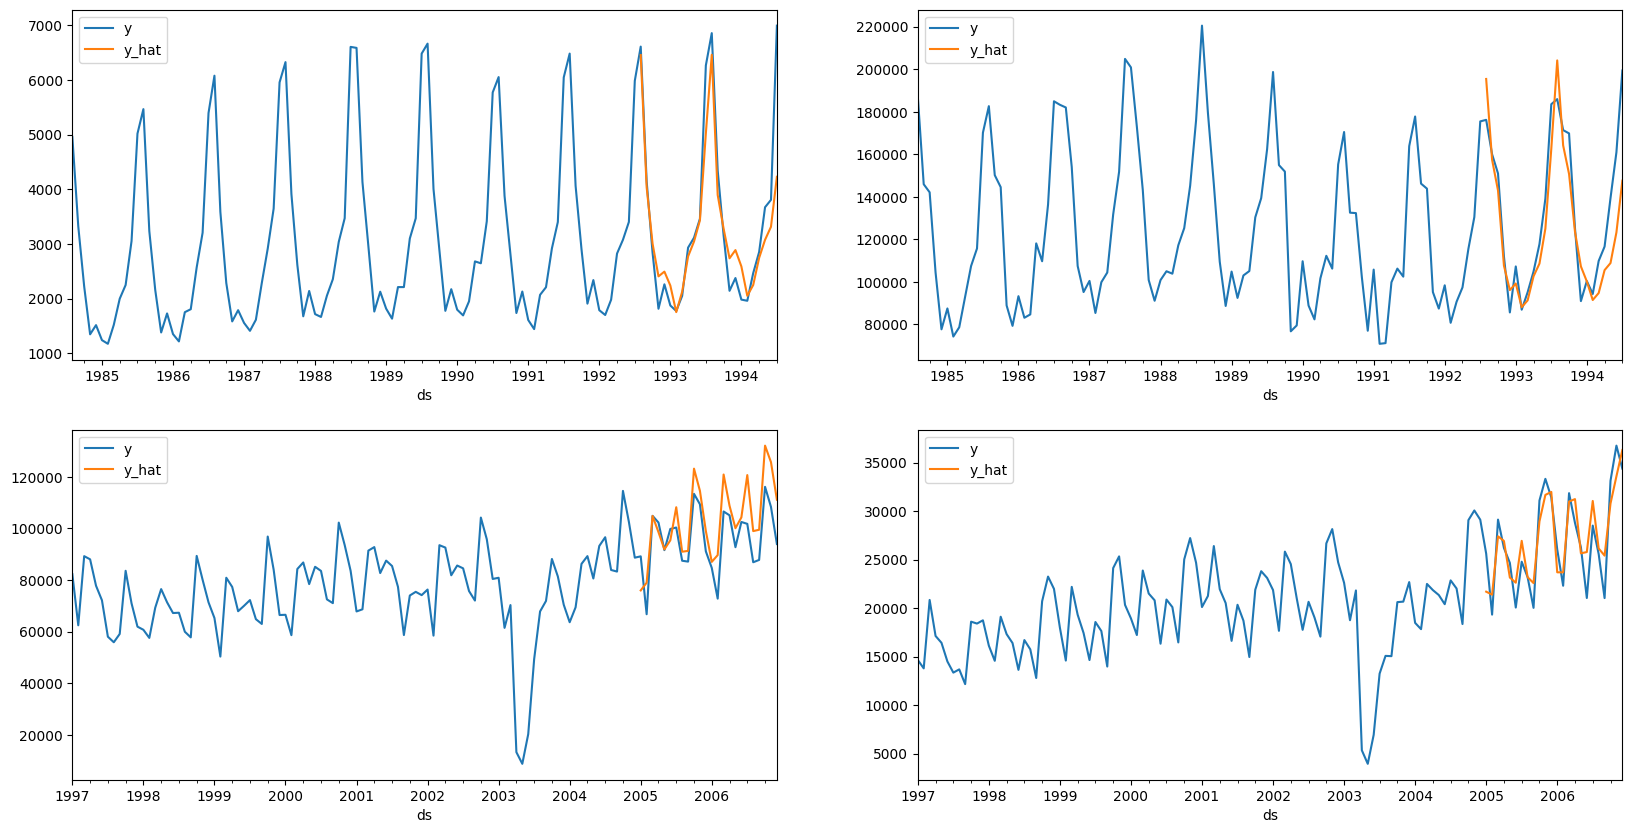

In [6]:
df_list = add_y_hat(df, y_hat, scenario.prediction_length)
sample_preds = plot(df_list, scenario.prediction_length)

In [45]:
scenario_list = [
    nnts.experiments.CovariateScenario(
        1, 0, conts=[], pearson=1, noise=0, covariates=0
    ),
    nnts.experiments.CovariateScenario(
        2, 0, conts=[], pearson=1, noise=0, covariates=0
    ),
    nnts.experiments.CovariateScenario(
        3, 0, conts=[], pearson=1, noise=0, covariates=0
    ),
]

In [50]:
for scenario in scenario_list:
    nnts.torch.data.datasets.seed_everything(scenario.seed)
    df, scenario = covs.prepare(df_orig.copy(), scenario)
    split_data = splitter.split(df, metadata)
    _, _, test_dl = nnts.data.map_to_dataloaders(
        split_data,
        metadata,
        scenario,
        params,
        nnts.torch.data.TorchTimeseriesDataLoaderFactory(),
    )
    name = f"cov-{scenario.covariates}-pearsn-{str(round(scenario.pearson, 2))}-pl-{str(scenario.prediction_length)}-seed-{scenario.seed}"
    logger = nnts.loggers.ProjectRun(
        nnts.loggers.JsonFileHandler(
            path=PATH, filename=f"{name}.json"
        ),
        #nnts.loggers.PrintHandler(),
        project=f"{model_name}-{metadata.dataset}",
        run=name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
    )

    net = nnts.torch.models.BaseLSTM(
    nnts.torch.models.LinearModel,
    params,
    preprocessing.masked_mean_abs_scaling,
    1,
)
    best_state_dict = torch.load(
        f"{PATH}/cov-{scenario.covariates}-pearsn-{str(round(scenario.pearson, 2))}-pl-{metadata.prediction_length}-seed-{scenario.seed}.pt"
    )
    net.load_state_dict(best_state_dict)
    evaluator = nnts.torch.models.trainers.TorchEvaluator(net)
    y_hat, y  = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, metadata.freq, metadata.seasonality
    )
    logger.log(test_metrics)
    logger.finish()

{'mse': 1670.5613, 'mae': 15.661198616027832, 'mape': 0.1860194, 'smape': 0.16618755459785461, 'abs_error': 12012.14, 'mase': 0.03411583, 'rmse': 15.661198616027832}
Run cov-0-pearsn-0-pl-1-seed-42 finished
{'mse': 2431.8867, 'mae': 18.15166473388672, 'mape': 0.2053845, 'smape': 0.17725756764411926, 'abs_error': 27844.654, 'mase': 0.040868536, 'rmse': 20.205808639526367}
Run cov-0-pearsn-0-pl-2-seed-42 finished
{'mse': 3771.8018, 'mae': 21.664867401123047, 'mape': 0.20165008, 'smape': 0.18028970062732697, 'abs_error': 49850.855, 'mase': 0.04702104, 'rmse': 24.965465545654297}
Run cov-0-pearsn-0-pl-3-seed-42 finished


In [3]:
csv_aggregator = covs.CSVFileAggregator(PATH, "results")
csv_aggregator()

,input_dim,hidden_dim,n_layers,dropout,output_dim,batch_size,lr,epochs,patience,rnn_type,...,valid_loss,elapsed_time,mse,mae,mape,smape,abs_error,mase,rmse,run_time
0,1,40,2,0.1,1,128,0.001,10,10,lstm,...,112.794624,3.941494,1774.690674,14.245945,0.160912,0.150393,10926.639648,0.031152,14.245945,40.359818
1,1,40,2,0.1,1,128,0.001,10,10,lstm,...,19.932472,3.866533,3706.501953,19.982769,0.199588,0.177383,183921.406250,0.043751,24.295332,39.542490
2,1,40,2,0.1,1,128,0.001,10,10,lstm,...,47.890865,3.710894,2261.822754,14.679703,0.136905,0.128296,33777.996094,0.032505,16.830046,37.128032
3,1,40,2,0.1,1,128,0.001,10,10,lstm,...,NaN,NaN,1670.561279,15.661199,0.186019,0.166188,12012.139648,0.034116,15.661199,0.063216
4,1,40,2,0.1,1,128,0.001,10,10,lstm,...,236.228989,3.816703,3697.840820,19.951029,0.198131,0.173882,183629.296875,0.043489,23.956459,38.078316
5,1,40,2,0.1,1,128,0.001,10,10,lstm,...,141.971207,3.917266,3548.477539,16.585184,0.167852,0.154954,25441.671875,0.036780,18.299492,39.471939
6,1,40,2,0.1,1,128,0.001,10,10,lstm,...,38.203362,3.620383,3284.456299,19.397114,0.188674,0.175577,178531.031250,0.042325,23.623789,37.307869
7,1,40,2,0.1,1,128,0.001,10,10,lstm,...,177.467606,3.805960,3672.114746,19.636208,0.191354,0.173249,180731.640625,0.042775,23.698406,38.554124
8,1,40,2,0.1,1,128,0.001,10,10,lstm,...,84.527367,3.654917,3476.146729,19.459932,0.191842,0.172705,179109.203125,0.042419,23.576635,37.460147
9,1,40,2,0.1,1,128,0.001,10,10,lstm,...,112.794624,3.957465,3553.329102,19.842558,0.208581,0.178912,182630.890625,0.043297,24.149797,39.320499


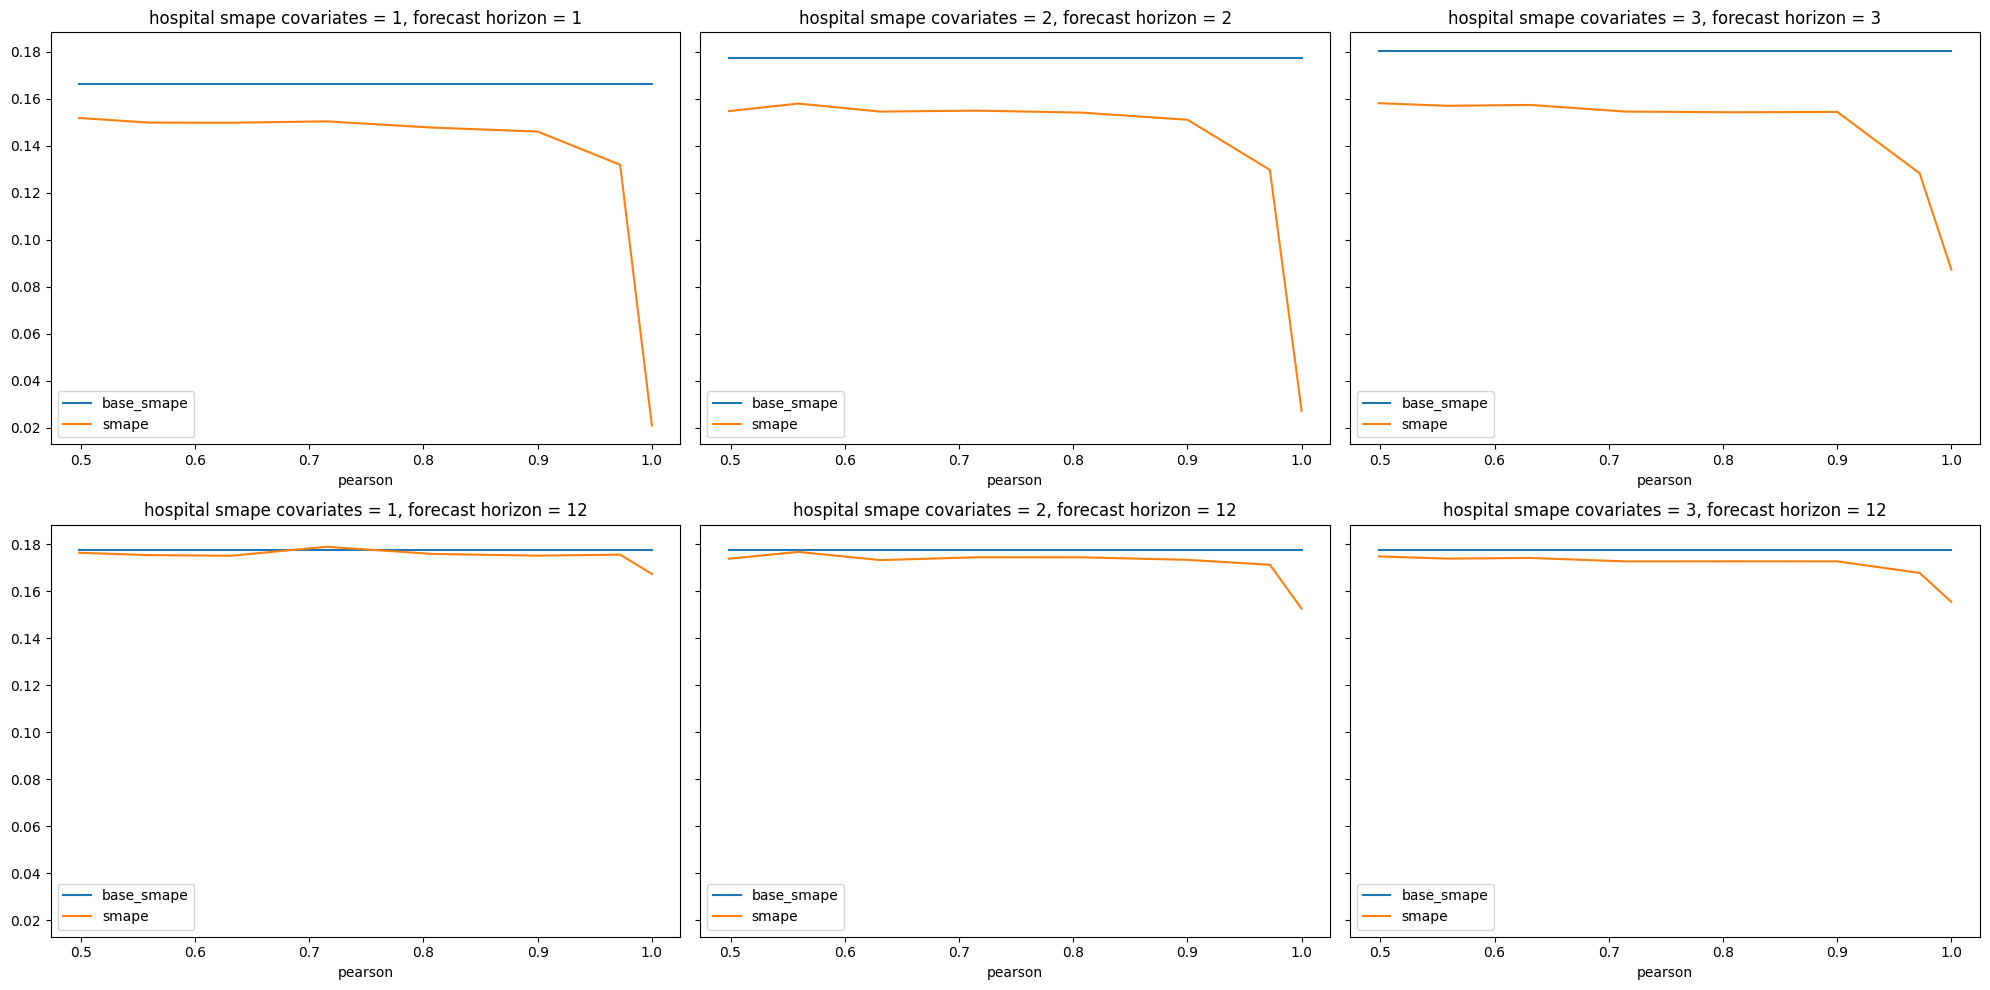

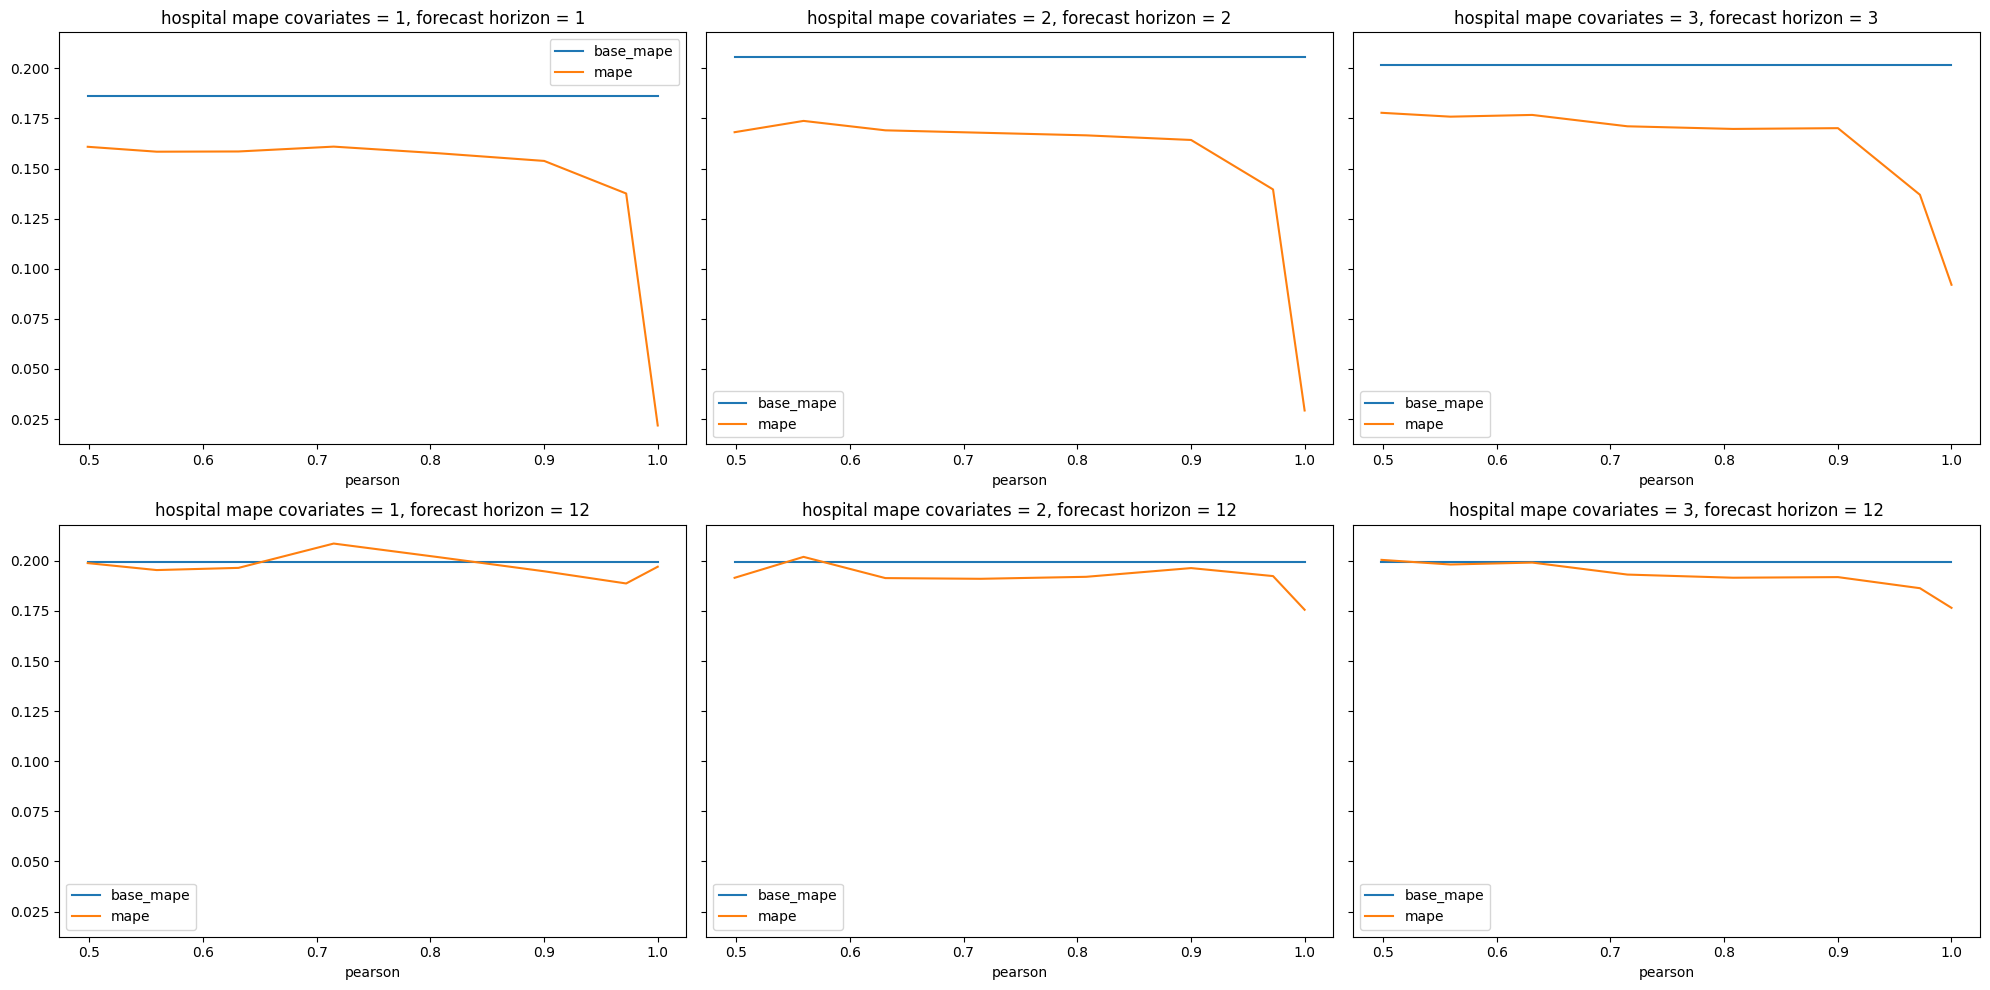

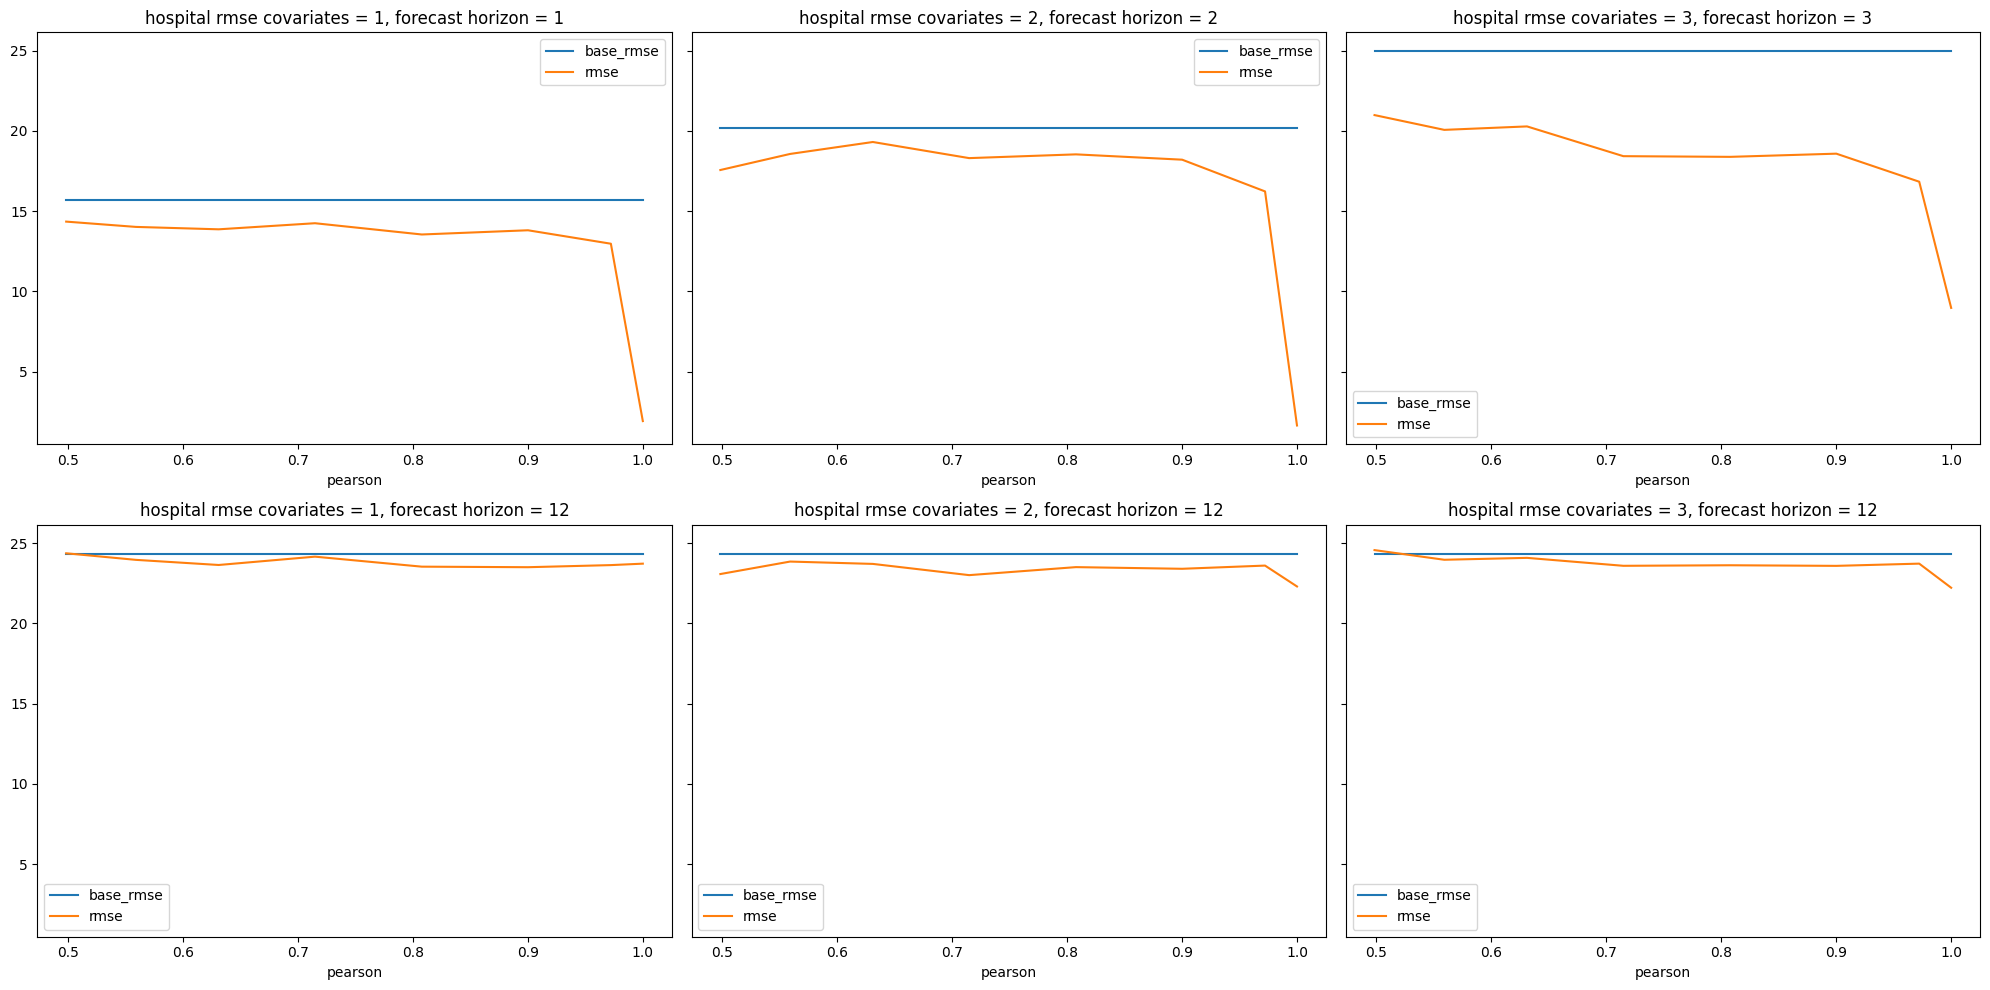

In [4]:
results = pd.read_csv(f"{PATH}/results.csv")

for metric in ["smape", "mape", "rmse"]:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharey=True)
    covs.get_chart_data(results, 1, 1, metric).plot(
        kind="line",
        ax=axes[0, 0],
        title=f"{metadata.dataset} {metric} covariates = 1, forecast horizon = 1",
    )
    covs.get_chart_data(results, 2, 2, metric).plot(
        kind="line",
        ax=axes[0, 1],
        title=f"{metadata.dataset} {metric} covariates = 2, forecast horizon = 2",
    )
    covs.get_chart_data(results, 3, 3, metric).plot(
        kind="line",
        ax=axes[0, 2],
        title=f"{metadata.dataset} {metric} covariates = 3, forecast horizon = 3",
    )
    covs.get_chart_data(results, metadata.prediction_length, 1, metric).plot(
        kind="line",
        ax=axes[1, 0],
        title=f"{metadata.dataset} {metric} covariates = 1, forecast horizon = {metadata.prediction_length}",
    )
    covs.get_chart_data(results, metadata.prediction_length, 2, metric).plot(
        kind="line",
        ax=axes[1, 1],
        title=f"{metadata.dataset} {metric} covariates = 2, forecast horizon = {metadata.prediction_length}",
    )
    covs.get_chart_data(results, metadata.prediction_length, 3, metric).plot(
        kind="line",
        ax=axes[1, 2],
        title=f"{metadata.dataset} {metric} covariates = 3, forecast horizon = {metadata.prediction_length}",
    )
    fig.tight_layout()
    fig.savefig(f"{PATH}/{metric}.png")